In [1]:
import os

# Change working directory to the BAYES folder
#os.chdir(r'C:\Users\solom\Desktop\BAYES')

In [1]:
#counts, bins, bars = plt.hist(x)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import optimize
import scipy
import bayesian_model as bm
#import plotting
import emcee

data = pd.read_csv('dielectron.csv')

data = data.dropna()
data = data[(data['Q1'] + data['Q2']) == 0]

# path = 'C:/Users/solom/Desktop/BAYES/'
# path_plots = 'C:/Users/solom/Desktop/BAYES/Plots/'

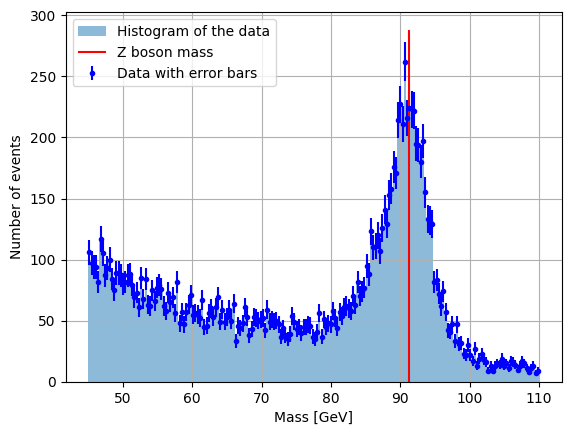

In [2]:
M_data = data['M'].values
#plt.hist(M_data, bins=200, range=(4, 125), alpha=0.5, label='Data')

y, bins, _ = plt.hist(M_data, bins=200, range=(45,110), alpha=0.5, label='Histogram of the data')
x = 0.5*(bins[1:]+bins[:-1])
y_errors = np.sqrt(y)  # Assuming Poisson statistics for the errors ----MAYBE ASK ABOUT THIS----

plt.errorbar(x, y, yerr=y_errors, fmt='.', color = 'b', label='Data with error bars')
plt.vlines(91.1876, 0, 1.1*np.max(y), color='r', label='Z boson mass')

plt.grid()
plt.xlabel('Mass [GeV]')
plt.ylabel('Number of events')

plt.legend()
plt.show()

counts = y
energies = x
counts_err = y_errors

<ErrorbarContainer object of 3 artists>

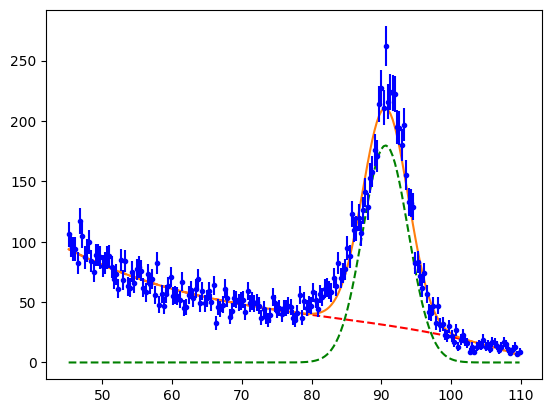

In [4]:
popt, pcov = optimize.curve_fit(bm.model_poly3, x, y, sigma=y_errors, p0 = [1000, 91, 2, 100, 100, 100, 100])
plt.plot(x, bm.background_poly3(x, popt[3], popt[4], popt[5], popt[6]), label='Background', color = 'red', linestyle='--')
plt.plot(x, bm.gauss_peak(x, popt[0], popt[1], popt[2]), label='Z-boson Peak', color = 'green', linestyle='--')
plt.plot(x, bm.model_poly3(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]), label='Fit', color = 'C1')

plt.errorbar(x, y, yerr=y_errors, fmt='.', color = 'b', label='Data with error bars')

In [5]:
print(popt)
a = popt[0]
mu = popt[1]
sigma = popt[2]
c0 = popt[3]
c1 = popt[4]
c2 = popt[5]
c3 = popt[6]

[ 1.79690290e+02  9.06168819e+01  3.26176642e+00  3.93988685e+02
 -1.13865159e+01  1.28276965e-01 -5.16835031e-04]


In [18]:
sig = 0.01

myclip_a = 0
myclip_b = np.inf

my_mean = 90
my_std = 90*sig
a2, b2 = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std


a_prior = scipy.stats.norm(loc=200, scale=50)
mu_prior = scipy.stats.norm(loc=91.187, scale=2)
sigma_prior = scipy.stats.uniform(loc=2, scale=3)

c0_x = 3.93988685e+02
c1_x = -1.13865159e+01
c2_x = 1.28276965e-01
c3_x = -5.16835031e-04


c0_prior = scipy.stats.norm(loc=c0_x, scale=c0_x*sig)
c1_prior = scipy.stats.norm(loc=c1_x, scale=-c1_x*sig)
c2_prior = scipy.stats.norm(loc=c2_x, scale=c2_x*sig)
c3_prior = scipy.stats.norm(loc=c3_x, scale=-c3_x*sig)


priors = [a_prior, mu_prior, sigma_prior, 
          c0_prior, c1_prior, c2_prior, c3_prior]


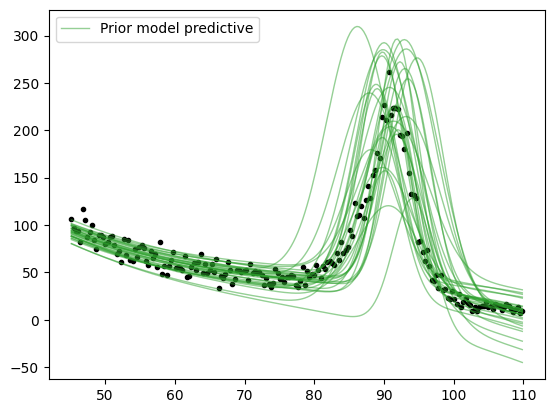

In [19]:
def sample_prior(n_sample, priors):
    """Sample n_sample times from the prior distribution."""
    
    return np.array([prior.rvs(n_sample) for prior in priors]).T

# Fix the pseudo random number generator seed for reproducibility
#np.random.seed(3)

# Evaluate the mode3 at the prior sample parameters
prior_model_predictive = np.array(
    [bm.model_poly3(x, *parameters) for parameters in sample_prior(n_sample=30, priors=priors)]
)

#print(sample_prior(n_sample=30, priors=priors))

style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'black')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

In [9]:
prior_predictive = np.random.poisson(lam=prior_model_predictive)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4, 8):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)

ValueError: lam < 0 or lam contains NaNs

MAP results
[ 1.80684969e+02  9.05887190e+01  3.29123416e+00  3.94309608e+02
 -1.13695475e+01  1.28309318e-01 -5.18003324e-04]


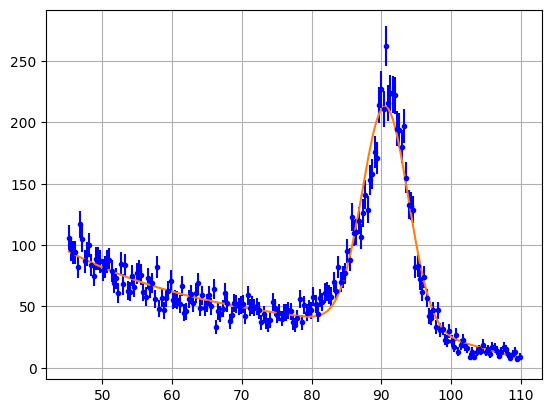

In [25]:
MAP_result = scipy.optimize.minimize(
    fun=bm.negative_log_posterior,
    x0=( 1.79690290e+02,  9.06168819e+01,  3.26176642e+00,  3.93988685e+02,
 -1.13865159e+01,  1.28276965e-01, -5.16835031e-04),
    args=(x, y, y_errors, bm.model_poly3, priors, 'poisson')
)

MAP_results = MAP_result.x

plt.errorbar(x, y, yerr=y_errors, fmt ='.', color = 'b', label='Data')
plt.plot(x, bm.model_poly3(x, *MAP_results), c="C1", label="MAP model")
plt.grid()

MAP_a1 = MAP_results[0]
MAP_mu1 = MAP_results[1]
MAP_sigma1 = MAP_results[2]
MAP_c0 = MAP_results[3]
MAP_c1 = MAP_results[4]
MAP_c2 = MAP_results[5]
MAP_c3 = MAP_results[6]


print("MAP results")
print(MAP_results)


In [26]:
np.random.seed(5)

# emcee requires some extra settings to run
n_param = 7       # Number of parameter we are sampling
n_walker = 30     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 8000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
# theta_init = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) \
#     + 0.1*np.random.normal(size=(n_walker, n_param))
    
theta_init = np.column_stack([
    a_prior.rvs(size=n_walker),
    mu_prior.rvs(size=n_walker),
    sigma_prior.rvs(size=n_walker),
    c0_prior.rvs(size=n_walker),
    c1_prior.rvs(size=n_walker),
    c2_prior.rvs(size=n_walker),
    c3_prior.rvs(size=n_walker),
])

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=bm.log_posterior_probability,
    args=(x, y, y_errors, bm.model_poly3, priors, 'poisson')
)
    
state = sampler.run_mcmc(theta_init, nsteps=n_step)


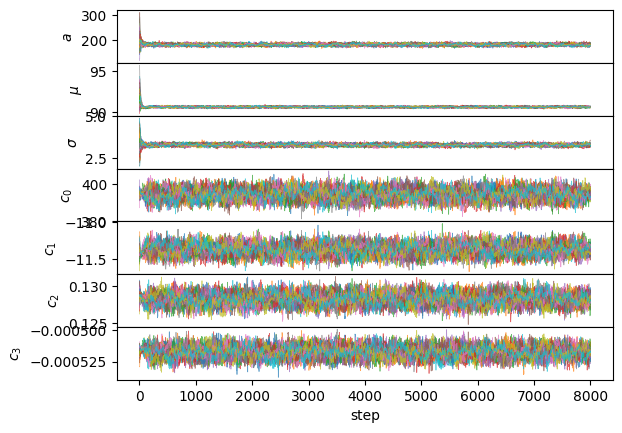

In [27]:
chain = sampler.get_chain()

n_walker = 30
param_names = [r"$a$", r"$\mu$", r"$\sigma$", r"$c_0$", r"$c_1$", r"$c_2$", r"$c_3$"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

In [28]:
tau = emcee.autocorr.integrated_time(chain)
print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
 print(f"{name}: {iat:.1f}")

Integrated auto-correlation time
$a$: 73.2
$\mu$: 53.7
$\sigma$: 68.6
$c_0$: 80.8
$c_1$: 77.7
$c_2$: 73.4
$c_3$: 71.8


In [29]:
max_autocorr = max(tau)
burn_in = int(10*max_autocorr)
thin = int(max_autocorr/2)

n_param = 7
chain = chain[burn_in::thin].reshape(-1, n_param)

#chain = sampler.get_chain(discard=1500, thin=10, flat=True)


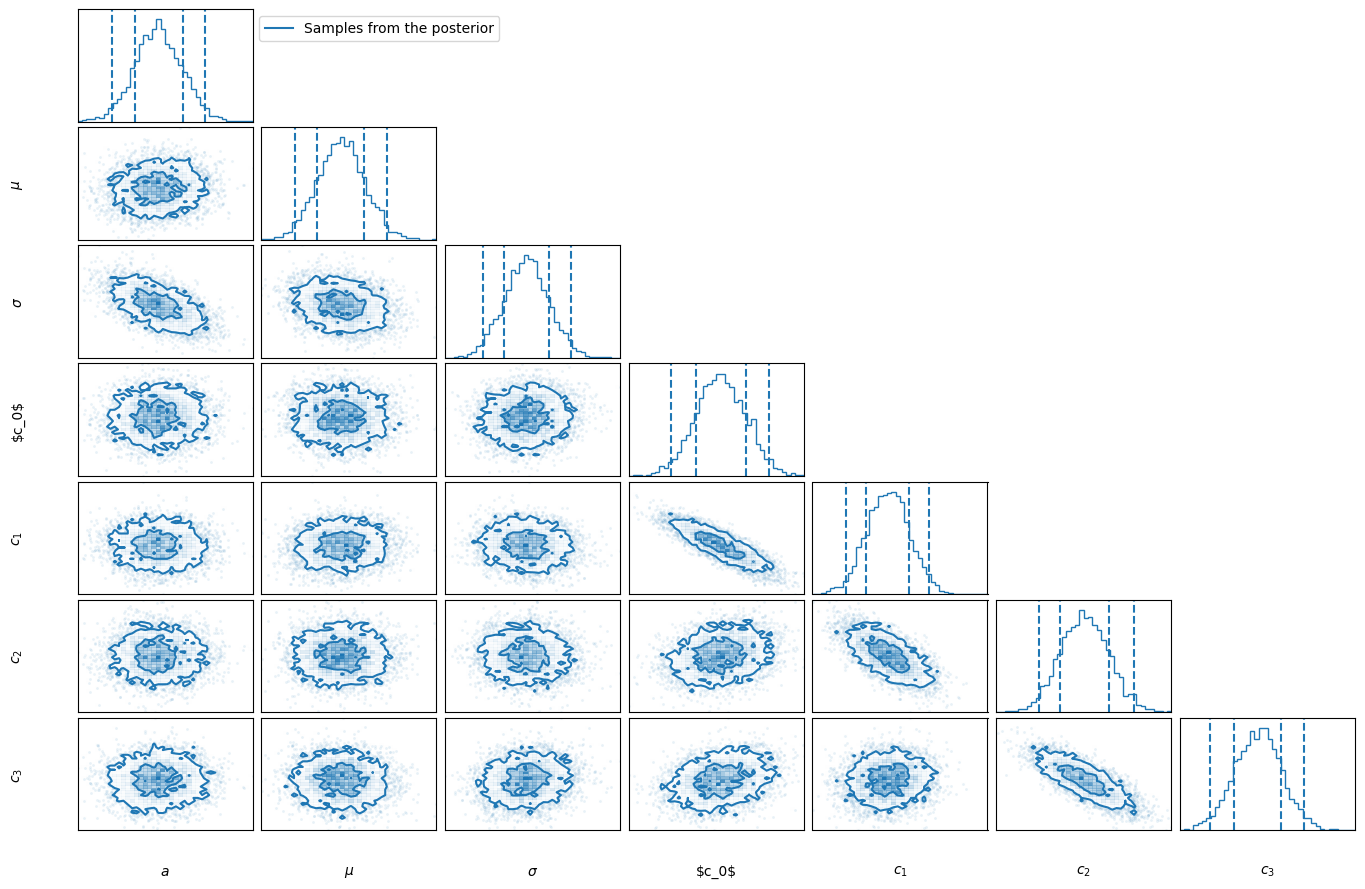

In [30]:
import corner
fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=[r"$a$", r"$\mu$", r"$\sigma$", r"\$c_0$", r"$c_1$", r"$c_2$", r"$c_3$"],
    color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
)
fig.get_axes()[0].plot([], [], c="C0", label="Samples from the posterior")
#fig.get_axes()[0].plot([], [], c="C1", label="True parameters")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))

# for ax in fig.get_axes():
#     ax.xaxis.label.set_size(12)  # Optional: Adjust font size if needed
#     ax.yaxis.label.set_size(12)
#     ax.xaxis.labelpad = 30       # Adjust label padding for x-axis
#     ax.yaxis.labelpad = 30       # Adjust label padding for y-axis

for ax in fig.get_axes():
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

fig.set_size_inches(14, 9)



<ErrorbarContainer object of 3 artists>

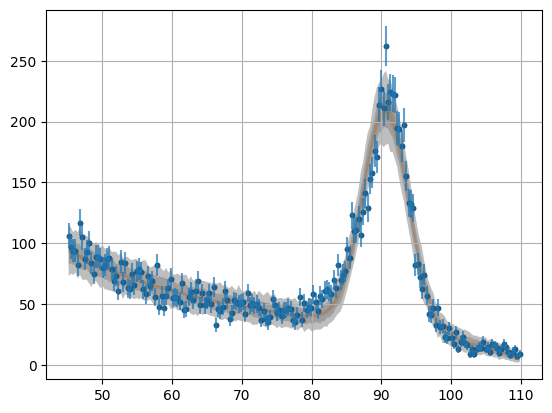

In [51]:
def sample_posterior(x, y, chain, model, seed=15, n_samples=200, plot=True):
    
    np.random.seed(seed)
    flat_chain = chain.reshape(-1, chain.shape[-1])
    chain_samples = flat_chain[np.random.choice(chain.shape[0], size=n_samples)]

    # Evaluate the model at the sample parameters
    model_predictive = np.array(
        [model(x, *sample) for sample in chain_samples]
    )
    model_quantiles = np.quantile(
        model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0
    )
    if plot == True:
        plt.grid()
        plt.fill_between(x, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1",
                    label="Model predictive distribution")
        plt.fill_between(x, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1")
        plt.plot(x, y, ".", color = 'black')
        
    return chain_samples, model_predictive

chain_samples, model_predictive = sample_posterior(x, y, chain, model_poly3)
def predict(params, x):
    lambda_model = model_poly3(x, *params)
    lambda_model = np.maximum(lambda_model, 0)

    # Draw from the Poisson distribution using the computed lambda
    return np.random.poisson(lam=lambda_model)

posterior_predictive = np.array(
        [predict(sample, x) for sample in chain_samples])

quantiles = np.percentile(posterior_predictive, [2.5, 16, 84, 97.5], axis=0)

plt.fill_between(x, quantiles[0], quantiles[-1], alpha=0.5, facecolor="C17",
                    label="Model predictive distribution")
plt.fill_between(x, quantiles[1], quantiles[-2], alpha=0.5, facecolor="C17")
plt.errorbar(x, y, yerr=y_errors, fmt=".", color="C10", label="Data", alpha=0.7)

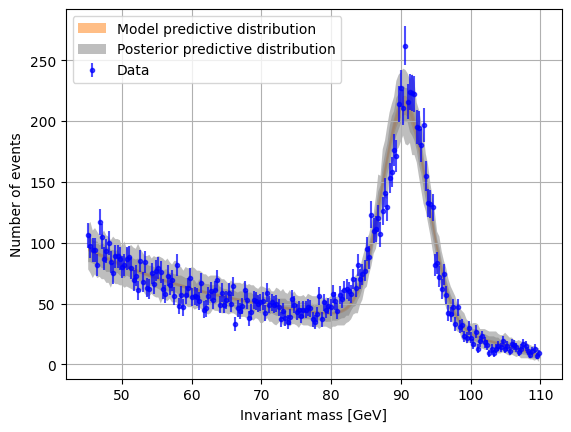

In [32]:
# Choose a small subsample of the chain for plotting purposes
#chain = np.load('emcee_chain_gauss_exp_30_walker_1.npy')
#chain = bm.process_chain(chain, discard=1000, thin=10, flat=True)

chain_samples, model_predictive, posterior_predictive = bm.sample_posterior(x, y, y_errors, chain, bm.model_poly3, mode='poisson')

In [35]:
def chi_squared(y, mu):
    return np.sum((y - mu)**2/mu)

def test_statistic(y, theta, x, model):
    mu = model(x, *theta)
    t = chi_squared(y, mu)
    return t

def ppd_model_check(test_statistic, y, ppd, ppd_params):
    t_data = []
    t_rep = []
    for y_rep, theta in zip(ppd, ppd_params):
        t_data.append(test_statistic(y, theta))
        t_rep.append(test_statistic(y_rep, theta))
        
    t_data = np.array(t_data)
    t_rep = np.array(t_rep)
    
    # print(t_data)
    # print(t_rep)
    
    pte = (t_rep >= t_data).sum()/len(t_data)
    return pte, t_rep, t_data



ppd = posterior_predictive

PPD_PTE_gauss_exp, t_rep_gauss_exp, t_gauss_exp = ppd_model_check(
                                    test_statistic=lambda y, theta: test_statistic(y, theta, x, bm.model_poly3),
                                    y=y,
                                    ppd=ppd,
                                    ppd_params=chain_samples
                                                                  )

print(f"Gauss + Exp: PPD PTE={PPD_PTE_gauss_exp:.3f}")

Gauss + Exp: PPD PTE=0.000


In [37]:
import dynesty

log_likelihood_gauss_exp = lambda theta: bm.log_likelihood_poisson(x, y, bm.model_poly3, theta)

def prior_transform_gauss_exp(u):
    x = np.array([
        a_prior.ppf(u[0]),
        mu_prior.ppf(u[1]),            
        sigma_prior.ppf(u[2]),
        c0_prior.ppf(u[3]),
        c1_prior.ppf(u[4]),
        c2_prior.ppf(u[5]),
        c3_prior.ppf(u[6])
    ])

    return x

sampler_gauss_exp = dynesty.NestedSampler(
    loglikelihood=log_likelihood_gauss_exp,
    prior_transform=prior_transform_gauss_exp,
    ndim=7,
    nlive=100,
)
sampler_gauss_exp.run_nested(print_progress=True)

sampler_gauss_exp.results.summary()

1527it [00:59,  3.37it/s, bound: 340 | nc: 241 | ncall: 54498 | eff(%):  2.802 | loglstar:   -inf < -733.154 <    inf | logz: -746.535 +/-  0.340 | dlogz:  0.371 >  0.109] c:\Users\ZenBook\Desktop\machine_learning\ML_tools\lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
1662it [01:28, 18.68it/s, +100 | bound: 530 | nc: 1 | ncall: 83078 | eff(%):  2.123 | loglstar:   -inf < -732.025 <    inf | logz: -746.320 +/-  0.349 | dlogz:  0.001 >  0.109]

Summary
nlive: 100
niter: 1662
ncall: 82978
eff(%):  2.123
logz: -746.320 +/-  0.404


In [36]:
np.save('emcee_chain_single_gauss_poly3.npy', sampler.get_chain())